#### Visualizing

In [1]:
import torch, torch_geometric

vis = torch.load('data/processed_unnormalized/data_165.pt') #5, 7, 12

print(vis)

Data(x=[22, 40], edge_index=[2, 128], y=[1])


In [2]:
# so the kernel doesn't die
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

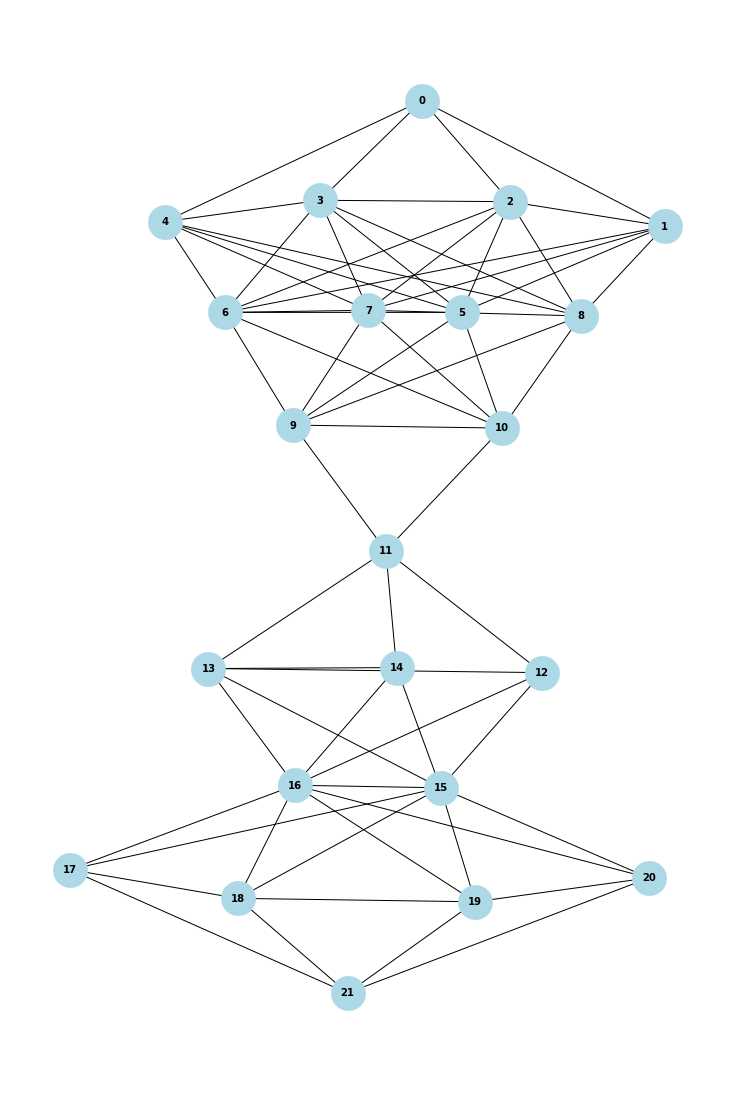

In [3]:
import networkx as nx
from torch_geometric.utils import to_networkx  # Conversion function
import matplotlib.pyplot as plt

plt.figure(figsize=(10,15))

G = to_networkx(vis, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_size=1200, \
    node_color='lightblue', linewidths=0.25, font_size=10, \
    font_weight='bold', with_labels=True)

plt.show()

## Esembling

### Load Models

In [4]:
import mlflow
import torch
import torch_geometric

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Models with Top10 Validation Accuracy 
# logged_model1 = 'runs:/403cd59c0eaf4c28907f986dfc629111/model'
# logged_model2 = 'runs:/4609b6f0266049dfb442e009d5c656c6/model'
# logged_model3 = 'runs:/68f88dd4cdf047ba943a1d8636e117ca/model'
# logged_model4 = 'runs:/10788afcaf1144069d635f891d24e048/model'
# logged_model5 = 'runs:/b277b848339b48ec9b77d9a269176e9e/model'
# logged_model6 = 'runs:/7dbad1b59322482db65c6588b6592a0f/model'
# logged_model7 = 'runs:/8bfc2ce6b4ee4b90aeea654a1f26d484/model'
# logged_model8 = 'runs:/fbd5821e87b540468003b24f6c599a95/model'
# logged_model9 = 'runs:/0d33321946ad48f388e17b2be3fd4abf/model'
# logged_model10 = 'runs:/3ea2aeba0e99478eb9d306b02e0077d0/model'

# Models with Top10 Validation F1
logged_model1 = 'runs:/44fdcf8a76764dc8b491cd4cda96c25f/model'
logged_model2 = 'runs:/9160e6562bca438da717497f7a42e3da/model'
logged_model3 = 'runs:/52061204dc4f44fca752a77d45ad4b00/model'
logged_model4 = 'runs:/d314a5aca4814bafb8432b8e465398b9/model'
logged_model5 = 'runs:/fb108f8e373c447498c001dfe1da1788/model'
logged_model6 = 'runs:/cf3156b4a60543789947186eb729f9f8/model'
logged_model7 = 'runs:/4d3923ecb58d4f31a895b2799842acef/model'
logged_model8 = 'runs:/8021451a8051497480cc4e25613e5d6a/model'
logged_model9 = 'runs:/287a4183099e4e1fa3d778434fa75cb7/model'
logged_model10 = 'runs:/d4363fdaac484887b266fc24a1b95fc6/model'

# Load model as a PyFuncModel.
loaded_model1 = mlflow.pytorch.load_model(logged_model1)
loaded_model2 = mlflow.pytorch.load_model(logged_model2)
loaded_model3 = mlflow.pytorch.load_model(logged_model3)
loaded_model4 = mlflow.pytorch.load_model(logged_model4)
loaded_model5 = mlflow.pytorch.load_model(logged_model5)
loaded_model6 = mlflow.pytorch.load_model(logged_model6)
loaded_model7 = mlflow.pytorch.load_model(logged_model7)
loaded_model8 = mlflow.pytorch.load_model(logged_model8)
loaded_model9 = mlflow.pytorch.load_model(logged_model9)
loaded_model10 = mlflow.pytorch.load_model(logged_model10)

models = [loaded_model1, loaded_model2, loaded_model3, loaded_model4, loaded_model5, 
          loaded_model6, loaded_model7, loaded_model8, loaded_model9, loaded_model10]

# Bypass aggr err
for model in models:
    for conv in model.conv_layers:
        conv.aggr_module = torch_geometric.nn.aggr.SumAggregation()

### Load Test Dataset

In [5]:
from processedDataset import ProcessedDataset
from torch_geometric.data import DataLoader

torch.manual_seed(42)

full_dataset = ProcessedDataset(root = "data/", filename = "fixtures_full.csv")
full_dataset.shuffle()
test_dataset = full_dataset[3800:]

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

C:\Users\sunny\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Predict

In [6]:
import numpy as np

def predict(model, test_loader):
    all_preds = []
    all_preds_raw = []
    all_labels = []

    for batch in test_loader:
        batch.x = torch.tensor(batch.x)
        batch.x = batch.x.reshape((-1, *batch.x.shape[2:]))
        batch.to(device)  
        pred = model(torch.tensor(batch.x).float(), 
                        #batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_preds_raw.append(torch.softmax(pred, axis=1).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    return all_preds, all_preds_raw, all_labels

In [7]:
all_pred = []
all_pred_raw = []
for model in models:
    model = model.to(device)
    model.eval()
    pred, pred_raw, label = predict(model, test_loader) # all_label -> true label for dataset
    all_pred.append(pred)
    all_pred_raw.append(pred_raw)

C:\Users\sunny\AppData\Local\Temp\ipykernel_3580\3776346709.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  batch.x = torch.tensor(batch.x)
C:\Users\sunny\AppData\Local\Temp\ipykernel_3580\3776346709.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(batch.x).float(),


In [8]:
all_pred_raw = np.array(all_pred_raw).squeeze()
all_pred_raw.shape # (10, 464, 3) -> 10 models, 464 data, 3 label confidence

(10, 464, 3)

In [9]:
np.array(all_pred).shape # (10, 464) -> 10 models, 464 data

(10, 464)

### Voting & Threshold(Highest Confidence Mean)
Use voting as the output of ensemble and only predict matches with higest confidence mean

In [10]:
from collections import Counter

vote_result = [Counter(col).most_common(1)[0][0] for col in zip(*all_pred)] # (464, )

In [11]:
# get confidence for every vote result
conf_nums = [] # shape -> (464, 10): 464 datas with 10 model confidences
for i, vote in enumerate(vote_result): # i -> which data, vote -> most predict with that data
    conf_nums.append([all_pred_raw[0][i][vote], all_pred_raw[1][i][vote], all_pred_raw[2][i][vote], all_pred_raw[3][i][vote], 
                      all_pred_raw[4][i][vote], all_pred_raw[5][i][vote], all_pred_raw[6][i][vote], all_pred_raw[7][i][vote], 
                      all_pred_raw[8][i][vote], all_pred_raw[9][i][vote]])

In [12]:
# calculate mean for every vote result
conf_mean = np.mean(conf_nums, axis=1) # shape -> (464,)

#### Get the highest 30%, 50%, 70%, 90%, 100% confidence mean data index

In [13]:
# number of data
thirty = int(len(conf_mean) * 0.3)
fifty = int(len(conf_mean) * 0.5)
seventy = int(len(conf_mean) * 0.7)
ninety = int(len(conf_mean) * 0.9)
hundred = int(len(conf_mean))

# Largest K elements indices
thirty = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:thirty] # size -> 139
fifty = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:fifty] # size -> 232
seventy = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:seventy] # size -> 324
ninety = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:ninety] # size -> 417
hundred = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:hundred] # size -> 464

#### Calculate the accuracy of these corresponding indices

thirty acc:  0.7985611510791367
fifty acc:  0.6422413793103449
seventy acc:  0.5648148148148148
ninety acc:  0.5251798561151079
hundred acc:  0.5086206896551724


Text(0.5, 42.0, 'Predicted label')

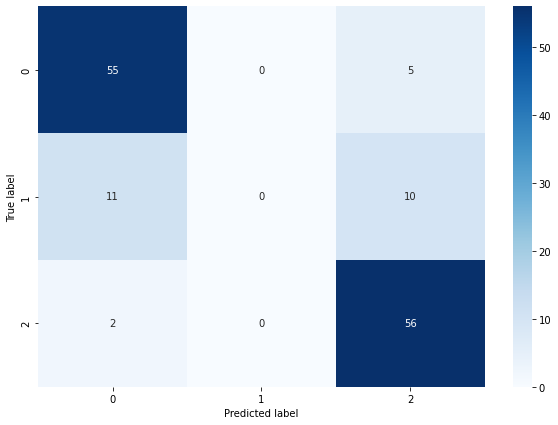

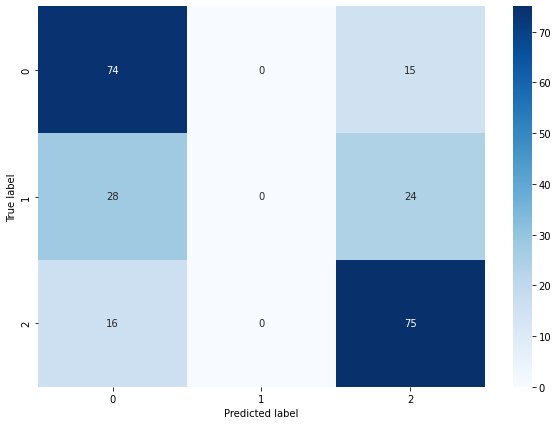

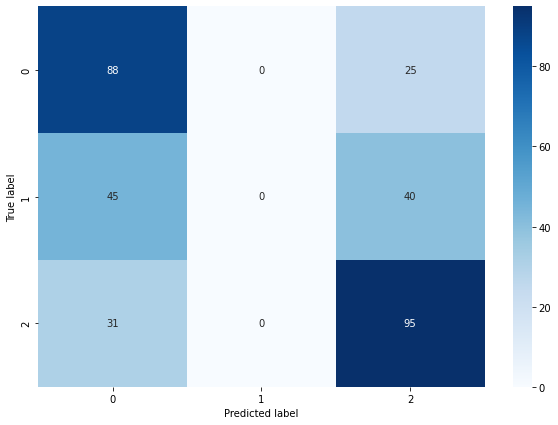

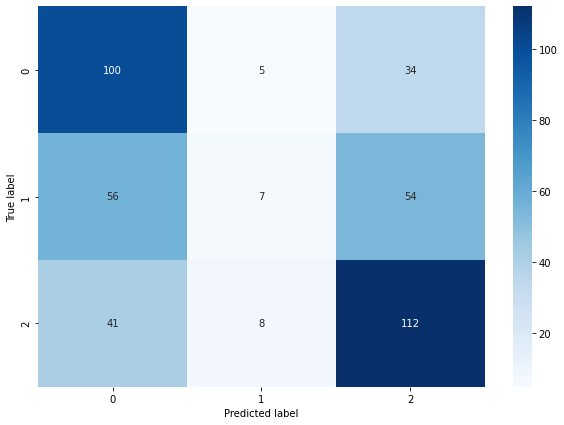

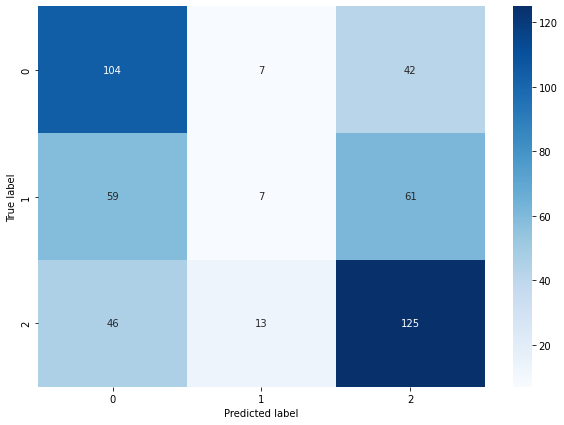

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# thirty
top_preds = [vote_result[i] for i in thirty]
top_labels = [label[i] for i in thirty]
acc1 = accuracy_score(top_labels, top_preds)
print("thirty acc: ", acc1)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# fifty
top_preds = [vote_result[i] for i in fifty]
top_labels = [label[i] for i in fifty]
acc2 = accuracy_score(top_labels, top_preds)
print("fifty acc: ", acc2)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# seventy
top_preds = [vote_result[i] for i in seventy]
top_labels = [label[i] for i in seventy]
acc3 = accuracy_score(top_labels, top_preds)
print("seventy acc: ", acc3)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# ninety
top_preds = [vote_result[i] for i in ninety]
top_labels = [label[i] for i in ninety]
acc4 = accuracy_score(top_labels, top_preds)
print("ninety acc: ", acc4)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# hundred
top_preds = [vote_result[i] for i in hundred]
top_labels = [label[i] for i in hundred]
acc5 = accuracy_score(top_labels, top_preds)
print("hundred acc: ", acc5)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

### Voting & Threshold(Smallest label variance)
Use the voting as the output of ensemble and use the variance of label predictions between models as the standard of threshold

In [ ]:
from collections import Counter

vote_result = [Counter(col).most_common(1)[0][0] for col in zip(*all_pred)] # (464, )

In [ ]:
# exchange the axis of all_pred
all_pred_transpose = [list(i) for i in zip(*all_pred)] # (10,464) to (464,10)

In [ ]:
# calculate label variance for every data
label_var = np.var(all_pred_transpose,axis=1) # shape -> (464,)

#### Get the least 30%, 50%, 70%, 90%, 100% label variance data index

In [ ]:
# number of data
thirty = int(len(label_var) * 0.3)
fifty = int(len(label_var) * 0.5)
seventy = int(len(label_var) * 0.7)
ninety = int(len(label_var) * 0.9)
hundred = int(len(label_var))

# Smallest K elements indices
thirty = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:thirty] # size -> 139
fifty = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:fifty] # size -> 232
seventy = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:seventy] # size -> 324
ninety = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:ninety] # size -> 417
hundred = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:hundred] # size -> 464

#### Calculate the accuracy of these corresponding indices

In [ ]:
from sklearn.metrics import accuracy_score

# thirty
top_preds = [vote_result[i] for i in thirty]
top_labels = [label[i] for i in thirty]
acc1 = accuracy_score(top_labels, top_preds)
print("thirty acc: ", acc1)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# fifty
top_preds = [vote_result[i] for i in fifty]
top_labels = [label[i] for i in fifty]
acc2 = accuracy_score(top_labels, top_preds)
print("fifty acc: ", acc2)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# seventy
top_preds = [vote_result[i] for i in seventy]
top_labels = [label[i] for i in seventy]
acc3 = accuracy_score(top_labels, top_preds)
print("seventy acc: ", acc3)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# ninety
top_preds = [vote_result[i] for i in ninety]
top_labels = [label[i] for i in ninety]
acc4 = accuracy_score(top_labels, top_preds)
print("ninety acc: ", acc4)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# hundred
top_preds = [vote_result[i] for i in hundred]
top_labels = [label[i] for i in hundred]
acc5 = accuracy_score(top_labels, top_preds)
print("hundred acc: ", acc5)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

### Avg Pred & Threshold(Highest Confidence Mean)
Ensemble Output: avg of pred between models

Standard of Threshold: Highest Confidence Mean

In [ ]:
from collections import Counter

raw_avg = np.mean(all_pred_raw, axis=0) # (10, 464, 3) -> (464, 3)
avg_result = np.argmax(raw_avg, axis=1) # (464, )

In [ ]:
# get confidence for every vote result
conf_nums = [] # shape -> (464, 10): 464 datas with 10 model confidences
for i, vote in enumerate(avg_result): # i -> which data, vote -> most predict with that data
    conf_nums.append([all_pred_raw[0][i][vote], all_pred_raw[1][i][vote], all_pred_raw[2][i][vote], all_pred_raw[3][i][vote], 
                      all_pred_raw[4][i][vote], all_pred_raw[5][i][vote], all_pred_raw[6][i][vote], all_pred_raw[7][i][vote], 
                      all_pred_raw[8][i][vote], all_pred_raw[9][i][vote]])

In [ ]:
# calculate mean for every vote result
conf_mean = np.mean(conf_nums, axis=1) # shape -> (464,)

#### Get the highest 30%, 50%, 70%, 90%, 100% confidence mean data index

In [ ]:
# number of data
thirty = int(len(conf_mean) * 0.3)
fifty = int(len(conf_mean) * 0.5)
seventy = int(len(conf_mean) * 0.7)
ninety = int(len(conf_mean) * 0.9)
hundred = int(len(conf_mean))

# Largest K elements indices
thirty = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:thirty] # size -> 139
fifty = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:fifty] # size -> 232
seventy = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:seventy] # size -> 324
ninety = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:ninety] # size -> 417
hundred = sorted(range(len(conf_mean)), key = lambda sub: conf_mean[sub], reverse=True)[:hundred] # size -> 464

#### Calculate the accuracy of these corresponding indices

In [ ]:
from sklearn.metrics import accuracy_score

# thirty
top_preds = [avg_result[i] for i in thirty]
top_labels = [label[i] for i in thirty]
acc1 = accuracy_score(top_labels, top_preds)
print("thirty acc: ", acc1)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# fifty
top_preds = [avg_result[i] for i in fifty]
top_labels = [label[i] for i in fifty]
acc2 = accuracy_score(top_labels, top_preds)
print("fifty acc: ", acc2)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# seventy
top_preds = [avg_result[i] for i in seventy]
top_labels = [label[i] for i in seventy]
acc3 = accuracy_score(top_labels, top_preds)
print("seventy acc: ", acc3)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# ninety
top_preds = [avg_result[i] for i in ninety]
top_labels = [label[i] for i in ninety]
acc4 = accuracy_score(top_labels, top_preds)
print("ninety acc: ", acc4)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# hundred
top_preds = [avg_result[i] for i in hundred]
top_labels = [label[i] for i in hundred]
acc5 = accuracy_score(top_labels, top_preds)
print("hundred acc: ", acc5)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

### Avg Pred & Threshold(Smallest label variance)
Ensemble Output: avg of pred between models

Standard of Threshold: Smallest label variance

In [ ]:
from collections import Counter

raw_avg = np.mean(all_pred_raw, axis=0) # (10, 464, 3) -> (464, 3)
avg_result = np.argmax(raw_avg, axis=1) # (464, )

In [ ]:
# exchange the axis of all_pred
all_pred_transpose = [list(i) for i in zip(*all_pred)] # (10,464) to (464,10)

In [ ]:
# calculate label variance for every data
label_var = np.var(all_pred_transpose,axis=1) # shape -> (464,)

#### Get the least 30%, 50%, 70%, 90%, 100% label variance data index

In [ ]:
# number of data
thirty = int(len(label_var) * 0.3)
fifty = int(len(label_var) * 0.5)
seventy = int(len(label_var) * 0.7)
ninety = int(len(label_var) * 0.9)
hundred = int(len(label_var))

# Smallest K elements indices
thirty = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:thirty] # size -> 139
fifty = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:fifty] # size -> 232
seventy = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:seventy] # size -> 324
ninety = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:ninety] # size -> 417
hundred = sorted(range(len(label_var)), key = lambda sub: label_var[sub])[:hundred] # size -> 464

#### Calculate the accuracy of these corresponding indices

In [ ]:
from sklearn.metrics import accuracy_score

# thirty
top_preds = [avg_result[i] for i in thirty]
top_labels = [label[i] for i in thirty]
acc1 = accuracy_score(top_labels, top_preds)
print("thirty acc: ", acc1)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# fifty
top_preds = [avg_result[i] for i in fifty]
top_labels = [label[i] for i in fifty]
acc2 = accuracy_score(top_labels, top_preds)
print("fifty acc: ", acc2)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# seventy
top_preds = [avg_result[i] for i in seventy]
top_labels = [label[i] for i in seventy]
acc3 = accuracy_score(top_labels, top_preds)
print("seventy acc: ", acc3)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# ninety
top_preds = [avg_result[i] for i in ninety]
top_labels = [label[i] for i in ninety]
acc4 = accuracy_score(top_labels, top_preds)
print("ninety acc: ", acc4)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

# hundred
top_preds = [avg_result[i] for i in hundred]
top_labels = [label[i] for i in hundred]
acc5 = accuracy_score(top_labels, top_preds)
print("hundred acc: ", acc5)
cm = confusion_matrix(top_labels, top_preds)
classes = ["0", "1", "2"]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
cfm_plot.set_ylabel('True label')
cfm_plot.set_xlabel('Predicted label')

## ---- ABANDON ----

### Voting & Threshold(Smallest Confidence Variance) X

In [ ]:
from collections import Counter

vote_result = [Counter(col).most_common(1)[0][0] for col in zip(*all_pred)] # (464, )

In [ ]:
# get confidence for every vote result
conf_nums = [] # shape -> (464, 10): 464 datas with 10 model confidences
for i, vote in enumerate(vote_result): # i -> which data, vote -> most predict with that data
    conf_nums.append([all_pred_raw[0][i][vote], all_pred_raw[1][i][vote], all_pred_raw[2][i][vote], all_pred_raw[3][i][vote], 
                      all_pred_raw[4][i][vote], all_pred_raw[5][i][vote], all_pred_raw[6][i][vote], all_pred_raw[7][i][vote], 
                      all_pred_raw[8][i][vote], all_pred_raw[9][i][vote]])

In [ ]:
# calculate variance for every vote result
conf_var = np.var(conf_nums,axis=1) # shape -> (464,)

#### Get the least 30%, 50%, 70%, 90%, 100% confidence variance data index

In [ ]:
# number of data
thirty = int(len(conf_var) * 0.3)
fifty = int(len(conf_var) * 0.5)
seventy = int(len(conf_var) * 0.7)
ninety = int(len(conf_var) * 0.9)
hundred = int(len(conf_var))

# Smallest K elements indices
thirty = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:thirty] # size -> 139
fifty = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:fifty] # size -> 232
seventy = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:seventy] # size -> 324
ninety = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:ninety] # size -> 417
hundred = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:hundred] # size -> 464

#### Calculate the accuracy of these corresponding indices

In [ ]:
from sklearn.metrics import accuracy_score

# thirty
top_preds = [vote_result[i] for i in thirty]
top_labels = [label[i] for i in thirty]
acc1 = accuracy_score(top_labels, top_preds)
print("thirty acc: ", acc1)

# fifty
top_preds = [vote_result[i] for i in fifty]
top_labels = [label[i] for i in fifty]
acc2 = accuracy_score(top_labels, top_preds)
print("fifty acc: ", acc2)

# seventy
top_preds = [vote_result[i] for i in seventy]
top_labels = [label[i] for i in seventy]
acc3 = accuracy_score(top_labels, top_preds)
print("seventy acc: ", acc3)

# ninety
top_preds = [vote_result[i] for i in ninety]
top_labels = [label[i] for i in ninety]
acc4 = accuracy_score(top_labels, top_preds)
print("ninety acc: ", acc4)

# hundred
top_preds = [vote_result[i] for i in hundred]
top_labels = [label[i] for i in hundred]
acc5 = accuracy_score(top_labels, top_preds)
print("hundred acc: ", acc5)

### Avg Pred & Threshold(Smallest Confidence Variance) X
Ensemble Output: avg of pred between models

Standard of Threshold: Smallest Confidence Variance

In [ ]:
from collections import Counter

raw_avg = np.mean(all_pred_raw, axis=0) # (10, 464, 3) -> (464, 3)
avg_result = np.argmax(raw_avg, axis=1) # (464, )

In [ ]:
# get confidence for every vote result
conf_nums = [] # shape -> (464, 10): 464 datas with 10 model confidences
for i, vote in enumerate(avg_result): # i -> which data, vote -> most predict with that data
    conf_nums.append([all_pred_raw[0][i][vote], all_pred_raw[1][i][vote], all_pred_raw[2][i][vote], all_pred_raw[3][i][vote], 
                      all_pred_raw[4][i][vote], all_pred_raw[5][i][vote], all_pred_raw[6][i][vote], all_pred_raw[7][i][vote], 
                      all_pred_raw[8][i][vote], all_pred_raw[9][i][vote]])

In [ ]:
# calculate variance for every vote result
conf_var = np.var(conf_nums,axis=1) # shape -> (464,)

#### Get the least 30%, 50%, 70%, 90%, 100% confidence variance data index

In [ ]:
# number of data
thirty = int(len(conf_var) * 0.3)
fifty = int(len(conf_var) * 0.5)
seventy = int(len(conf_var) * 0.7)
ninety = int(len(conf_var) * 0.9)
hundred = int(len(conf_var))

# Smallest K elements indices
thirty = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:thirty] # size -> 139
fifty = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:fifty] # size -> 232
seventy = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:seventy] # size -> 324
ninety = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:ninety] # size -> 417
hundred = sorted(range(len(conf_var)), key = lambda sub: conf_var[sub])[:hundred] # size -> 464

#### Calculate the accuracy of these corresponding indices

In [ ]:
from sklearn.metrics import accuracy_score

# thirty
top_preds = [avg_result[i] for i in thirty]
top_labels = [label[i] for i in thirty]
acc1 = accuracy_score(top_labels, top_preds)
print("thirty acc: ", acc1)

# fifty
top_preds = [avg_result[i] for i in fifty]
top_labels = [label[i] for i in fifty]
acc2 = accuracy_score(top_labels, top_preds)
print("fifty acc: ", acc2)

# seventy
top_preds = [avg_result[i] for i in seventy]
top_labels = [label[i] for i in seventy]
acc3 = accuracy_score(top_labels, top_preds)
print("seventy acc: ", acc3)

# ninety
top_preds = [avg_result[i] for i in ninety]
top_labels = [label[i] for i in ninety]
acc4 = accuracy_score(top_labels, top_preds)
print("ninety acc: ", acc4)

# hundred
top_preds = [avg_result[i] for i in hundred]
top_labels = [label[i] for i in hundred]
acc5 = accuracy_score(top_labels, top_preds)
print("hundred acc: ", acc5)